<a href="https://colab.research.google.com/github/prakash-2002-ramanathan/object_detection-text_recognition/blob/main/Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simple Voice Assistant for Visually Challenged
In this Project, I have utilized tesseract for text recognition, and Yolov for object recognition. Then I have used the built in text to speech converter, to give a coherent description of the surroundings to the user. The UI is built using Java Script, there is no backend.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,592 kB/s)
debconf: unable to initia

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image 
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import Audio
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
#from PIL import Image
import pytesseract
import io
import html
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Cloning and Setting Up Darknet for YOLOv4
 AlexeyAB's darknet repository is used

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


### Running on Webcam Video

In [ ]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

chmod +x *.sh


In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2022-11-24 04:51:47--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 172.253.119.102, 172.253.119.138, 172.253.119.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.119.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/shhkjh7vq50hb414joqkvnu1nuahmbg0/1669265475000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=328d9be1-916c-43fc-9ef7-6bb337aa7557 [following]
--2022-11-24 04:51:47--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/shhkjh7vq50hb414joqkvnu1nuahmbg0/1669265475000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=328d9be1-916c-43fc-9ef7-6bb337aa7557
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 142.251.6.13

## Darknet for Python
In order to utilize YOLOv4 with Python code some pre-built functions found within darknet.py are required, so we import functions into our workstation. 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## YOLOv4 Example on Test Image
Testing

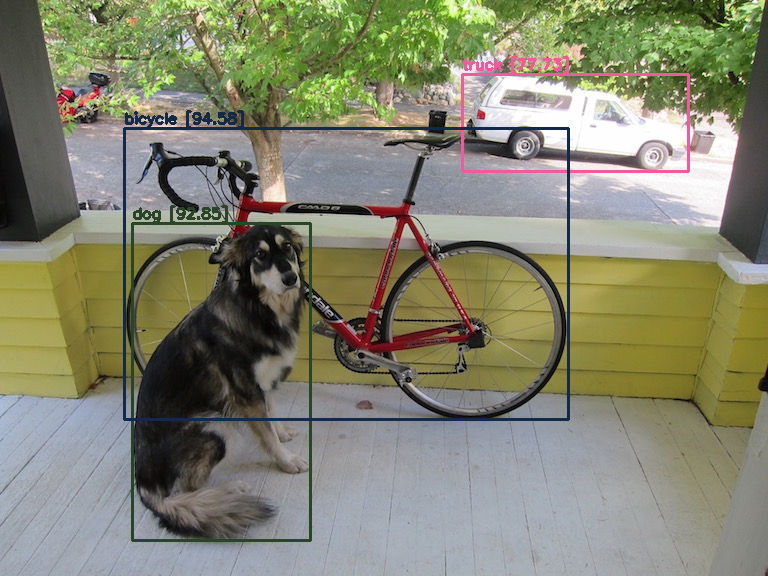

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("data/dog.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  if(float(confidence) > 50):
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
    
  
cv2_imshow(image)



## Helper Functions


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1]) #index img location[1]
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8) # used to conver the bytes to array   \x01\x02 to [1,2]
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA') # creating an image from array
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


  #pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

#############################################    BINARY FUNCTION

def binarize(image_to_transform, threshold):
    gray = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    invert = 255 - thresh
    return invert


## YOLOv4 on Wecam Images
To run YOLOv4 on images taken from a webcam, one can utilize the code within Google Colab's Code Snippets that has a variety of useful code functions to perform various tasks.

The process involves using the code snippet for Camera Capture which runs JavaScript code to access your computer's webcam. The code snippet captures a photo using the webcam, which is then passed into the YOLOv4 model for object detection.

A function is provided below to take the webcam picture using JavaScript and subsequently run YOLOv4 on it.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):  # this is a python function , Everything is inside this
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const img = document.createElement('img');
      img.src="";
      div.appendChild(img);

      const audio = document.createElement('button');
      const audio1 = new Audio('happy.mp3');
      audio.textContent = 'audio';
      div.appendChild(audio);
      
      audio.addEventListener("click", () => {
        //audio1.play();
        speechSynthesis.speak(new SpeechSynthesisUtterance("Hello, this is your browser speaking."));
        });
      

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});          //important

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      //google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))  #evaluates all javascript within current cell
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  thresh = 150
  print("\nTrying with threshold \n" + str(thresh))
  image = PIL.Image.fromarray(img)
  text = pytesseract.image_to_string(binarize(img, thresh), lang='eng', config='--psm 6') ## we are binarizing using threshold value
  text = text.strip()
  text = text.replace("\n", " ")
  print(text)
  print(len(text))

  #print(type(image))

  return filename

<IPython.core.display.Javascript object>


Trying with threshold 
150
gs
2
Saved to photo.jpg


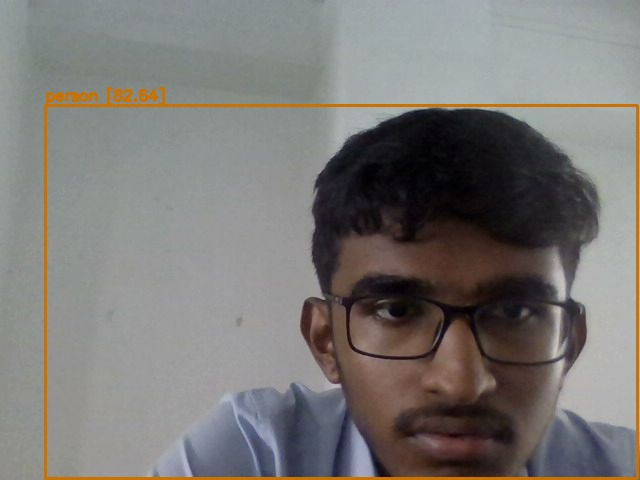

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Video Feed
Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLOv4.

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var yes = false;
    var div = null;
    var tread = false;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {  // function  to animate
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    





    async function createDom() {
      if (div !== null) {
        return stream;
      }

      const myStyles = `  background-color: #4CAF50; /* Green */
  border: none;
  color: white;
  padding: 16px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  transition-duration: 0.4s;
  cursor: pointer;`;

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
////////////////////////////////////////////

      //div2 = document.createElement('div2');
      const audio = document.createElement('button');
      audio.style.cssText = myStyles;
      audio.textContent = 'read objects';
      div.appendChild(audio);
      audio.addEventListener("click", () => {
        //audio1.play();
        yes = true
        });

      const tech1 = document.createElement('button');
      tech1.textContent = 'read text';
      tech1.style.cssText = myStyles;
      div.appendChild(tech1);
      tech1.addEventListener("click", () => {
        tread = true
        });
      

/////////////////////////////////////////////
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";


      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';

      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

/////////////////////////////////////////////////////////

      const reading = document.createElement('div');
      reading.innerHTML = "<span>Recognised Text: </span>"

      label2 = document.createElement('span');
      label2.innerText = 'No data';
      label2.style.fontWeight = 'bold';

      reading.appendChild(label2);
      div.appendChild(reading);

////////////////////////////////////////////////////////
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }











    async function stream_frame(label, imgData, text, recog) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData; //embeding the modified image
        labelElement.innerHTML = text;
        label2.innerHTML = recog;
      }

      if(yes){ 
        speechSynthesis.speak(new SpeechSynthesisUtterance(text));
        yes = false;
      }

      if(tread){ 
        //label2.innerHTML = recog;
        speechSynthesis.speak(new SpeechSynthesisUtterance(recog));
        tread = false;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;


/////////////////////////////////////////


      

////////////////////////////////////////////

      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
    
def video_frame(label, bbox, text, text1 ):
  data = eval_js('stream_frame("{}", "{}", "{}", "{}")'.format(label, bbox, text, text1))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
objects='a '
count = 0 
text1= " Not detected, try moving the text closer "
while True:
    time.sleep(1)
    js_reply = video_frame(label_html, bbox, objects, text1)
    objects='a '
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)
      objects=objects +"  "+label

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    #################################
    thresh = 150
    #print("\nTrying with threshold \n" + str(thresh))
    image = PIL.Image.fromarray(frame)
    
    text2 = pytesseract.image_to_string(binarize(frame, thresh), lang='eng', config='--psm 6')
    text1 = " "
    for i in text2 :
      if(i=="\n"):
        text1 += "  "
      elif(i=="\t"):
        text1 +="  "
      elif((i in '[@_!#$%^&*()<>?/\|}{~:]') or i.isalnum()or i==" "):
        text1+=i
      else:
        pass
    #text1 = "Not detected "
    

    ##################################


    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
!pwd

/content/darknet
